In [1]:
import os, glob, shutil, sys, copy, time, json, copy, subprocess
from IPython import display
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, color, transform, exposure
from skimage.filters import threshold_mean, sobel
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows, crop
import imagej
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
import warnings

from acquisitions import *
from image_utils import *

In [2]:
# os.environ['JAVA_MEM'] = '-Xmx4096m'
os.environ['_JAVA_OPTIONS']="-Xmx12g"
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None        

In [3]:
config = {
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg" : 0.255, # 0.509 micron/pixel at 256
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),  
    "slide-size" : (38000.0, 18000.0), # (width, height) (70000, -20000)
    "slide-start" : (0, 0), # x, y
    "Z-stage-20x" : -6930, # -6930 + 290
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15000, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-2000.0, 40000.0),
    "hard-limit-y" : (-2000, 20000.0),
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-590, 74), # 4x + this value to 20x
    "shg-offset" : (-580, -172), # 4x + this value to shg
    "lsm-resolution" : 512,
    "lsm-bin-factor" : 3,
    "lsm-scan-rate" : '500000.0000',
    "lsm-pc-power" : 0.4, # 1
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}
# 4x position list is in row x column x z (generate by generate_grid function), 20x and shg position lists are in pos x z, order is x, y

In [4]:
def resample_z_pos(config, mag='20x', xy_pos=None, xyz_pos_list_4x=None, xyz_pos_list_20x=None):
    if xyz_pos_list_4x is not None:
        xy_pos_list = xyz_pos_list_4x[:, :, :2] # x, y, z
        z_pos_list = xyz_pos_list_4x[:, :, 2]
    #     list_w = xyz_pos_list[-1, -1, 0] - xyz_pos_list[0, 0, 0] # first pos, width
    #     list_h = xyz_pos_list[-1, -1, 1] - xyz_pos_list[0, 0, 1] # last pos, height
    #     resample_w = int(np.rint(list_w / 50))
    #     resample_h = int(np.rint(list_h / 50))
        list_h = xyz_pos_list_4x.shape[0]
        list_w = xyz_pos_list_4x.shape[1]
        dense_xy = transform.resize(xy_pos_list, (list_h*100, list_w*100), order=1, preserve_range=True, mode='edge')
        dense_z = transform.resize(z_pos_list, (list_h*100, list_w*100), order=3, preserve_range=True, mode='edge')
        dense_xyz = np.concatenate((dense_xy, dense_z[:, :, None]), axis=2)
    #     print(dense_z)
        xyz_list = np.ones((xy_pos.shape[0], 3))
        for i in range(xy_pos.shape[0]):
            x_pos_source = xy_pos[i, 0]
            y_pos_source = xy_pos[i, 1]
            if mag=='20x': # transfer back to input grid position (4x)
                z_offset = config["Z-stage-20x"] - config["Z-stage-4x"]
                x_pos = x_pos_source - config["20x-bf-offset"][0]
                y_pos = y_pos_source - config["20x-bf-offset"][1]
            if mag=='mp':
                z_offset = config["Z-stage-laser"] - config["Z-stage-4x"]
                x_pos = x_pos_source - config["shg-offset"][0]
                y_pos = y_pos_source - config["shg-offset"][1]
            x_idx = np.abs(dense_xyz[0, :, 0] - x_pos).argmin()
            y_idx = np.abs(dense_xyz[:, 0, 1] - y_pos).argmin()
            z_pos = dense_xyz[y_idx, x_idx, 2] + z_offset
            xyz_list[i] = [x_pos_source, y_pos_source, z_pos]
    if xyz_pos_list_20x is not None:
        xyz_list = np.ones((xy_pos.shape[0], 3))
        for i in range(xy_pos.shape[0]):
            x_pos_source = xy_pos[i, 0] 
            y_pos_source = xy_pos[i, 1]       
            if mag=='20x': # transfer back to input grid position (20x)
                z_offset = 0
                x_pos = x_pos_source
                y_pos = y_pos_source
            if mag=='mp':
                z_offset = config["Z-stage-laser"] - config["Z-stage-20x"]
                x_pos = x_pos_source - config["shg-offset"][0] + config["20x-bf-offset"][0] 
                y_pos = y_pos_source - config["shg-offset"][1] + config["20x-bf-offset"][1]
            distance = np.sqrt((x_pos-xyz_pos_list_20x[:, 0])**2 + (y_pos-xyz_pos_list_20x[:, 1])**2)
            idx = np.argmin(distance)
            z_pos = xyz_pos_list_20x[idx, 2] + z_offset
            xyz_list[i, :] = np.array([x_pos_source, y_pos_source, z_pos])
    return xyz_list # x, y, z

In [5]:
def generate_grid(config, mag='4x', mod='bf', box=None, overlap=50, xyz_pos_list=None, z_offset=0):
    if box is not None:
        s_x = box[0]
        s_y = box[1]
        e_x = box[2]
        e_y = box[3]
    else:
        s_x = config["slide-start"][0]
        s_y = config["slide-start"][1]
        e_x = config["slide-start"][0] + config["slide-size"][0]
        e_y = config["slide-start"][1] + config["slide-size"][1]
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        field_w = config["camera-resolution"][0] * pixel_size
        field_h = config["camera-resolution"][1] * pixel_size
    if mod == 'shg':
        if mag == '20x':
            pixel_size = config["pixel-size-shg"]
        if mag == '4x':
            raise ValueError('Not supported magnification for LSM')
        field_w = config["lsm-resolution-base"][0] * pixel_size
        field_h = config["lsm-resolution-base"][1] * pixel_size
    field_o = overlap * pixel_size
    grid_w = int(np.ceil((e_x - s_x) / (field_w - field_o)))
    grid_h = int(np.ceil((e_y - s_y) / (field_h - field_o)))
    xy_list = np.zeros((grid_h, grid_w, 2))
    for x in range(grid_w):
        for y in range(grid_h):
            x_pos = x * (field_w - field_o) + s_x
            y_pos = y * (field_h - field_o) + s_y
            xy_list[y, x] = [x_pos, y_pos] # x, y
    return xy_list # row, col

def whole_slide_scan(config, core=None, save_path=None, acq_name=None, position_list=None, mag='4x', mda=False, z_stack=False, z_center=None, sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if position_list.shape[1] == 3:
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_center is None:
                z_center = config["Z-stage-laser"]
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
#         search_range_base = 1000
        redive_flag = True
        bg_flag = False
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        if position_list.shape[1] == 3:
            tile_count = 0
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            core.set_focus_device(config["focus-device"])                
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2).reshape(position_list.shape[0], 3)
#             position_list = position_list.reshape(position_list.shape[0]*position_list.shape[1], position_list.shape[2])
            for pos in range(position_list.shape[0]):
                z_pos = position_list[pos, 2]
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                    or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                    print('position out of range')
                    break
                core.set_position(z_pos)
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.wait_for_device(xy_device)
                core.wait_for_device(z_device)
                if focus_dive and mag=='4x':
                    if redive_flag:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=1000, steps=5, snap=False)
                        if not bg_flag:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=200, steps=5, snap=True)
                    else:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=200, steps=5, snap=True)
                    z_positions[pos] = pos_z
                if focus_dive and mag=='20x':
#                     if redive_flag:
                    if True:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=210, steps=7, check_background=True, snap=False)
                        if not bg_flag:
                            pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=50, steps=5, check_background=False, snap=False)
                            pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=10, steps=5, check_background=False, snap=True)
#                     else:
#                         pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=70, steps=7, check_background=True, snap=False)
#                         pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=10, steps=5, check_background=False, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False  
                if background_image is not None:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
                    
        if position_list.shape[1] == 2:
            tile_count = 0
#             core.set_focus_device(config["focus-device"])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
#             position_list = position_list.reshape(position_list.shape[0], position_list.shape[1], 2)
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                    print('position out of range')
                    break
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                core.wait_for_device(xy_device)
                if focus_dive and mag=='4x':
                    if redive_flag:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=1000, steps=5, snap=False)
                        if not bg_flag:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=250, steps=5, snap=True)
                    else:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=500, steps=5, snap=True)
                    z_positions[pos] = pos_z
                if focus_dive and mag=='20x':
#                     if redive_flag:
                    if True:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=210, steps=7, check_background=True, snap=False)
                        if not bg_flag:
                            pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=50, steps=5, check_background=False, snap=False)
                            pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=10, steps=5, check_background=False, snap=True)
#                     else:
#                         pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=70, steps=7, check_background=True, snap=False)
#                         pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=10, steps=5, check_background=False, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False                
                if background_image is not None:
                    pixels = white_balance(config, pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            returns.append((sum_img / sum_count))
            io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(np.squeeze(sum_img / sum_count)))
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], 1)
            returns.append(z_positions)
        return tuple(returns)

In [6]:
def autofocus(config, core, method='edge', mag='4x', rgb=True, search_range=45, steps=5, snap=True, crop_ratio=1.0, flip_channel=True, check_background=True, offset=0):
    if mag=='4x':
        drift_limit = config["Z-stage-4x"]
    if mag=='20x':
        drift_limit = config["Z-stage-20x"]
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = search_range/steps
    scores = []
    positions = []
    count = 0
    for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
        position_z = step * interval_z + current_z
        if position_z < config["hard-limit-z"][0] or position_z > config["hard-limit-z"][1]:
            print("z-stage out of range, new focus discarded")
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if check_background and step==-int(np.floor(steps/2)):
            bg_flag = is_background(pixels)
            if bg_flag:
                core.set_position(current_z)
                core.wait_for_system()
                print("Is background")
                return current_z, pixels, bg_flag
        img_gray = color.rgb2gray(pixels)
        print("\n Diving focus at " + str(step))
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        if method == 'edge':
            score = np.mean(sobel(img_gray))
#         print(str(score) + " " + str(position_z))
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions) 
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    if focus_z < config["hard-limit-z"][0] or focus_z > config["hard-limit-z"][1]:
        print("z-stage out of range, new focus discarded")
        focus_z = position_z
    if np.abs(focus_z-drift_limit) > 1000:
        print("z-stage out of range, reset focus")
        focus_z = drift_limit
        core.set_position(drift_limit)
        core.wait_for_system()
    else:
        core.set_position(focus_z)
        core.wait_for_system()
    if snap:
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        return focus_z+offset, pixels, False
    else:
        return focus_z+offset, None, False

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        core.wait_for_system()
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        core.wait_for_system()
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    return position_list_z

In [7]:
def export_slide(mag='4x', remove_file=True):
    print('exporting slides, please wait...')
    if mag=='4x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-4x.groovy')
    if mag=='20x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-20x.groovy')
    if mag=='mp':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-mp.groovy')       
    qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
    image_dirs = glob.glob(os.path.join('data', 'slides', mag, '*.tif'))
    for img_dir in image_dirs:
        if img_dir.find("ome") != -1:
            continue
        subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)
        if remove_file:
            os.remove(img_dir)
        
def annotations_positionlist(config, image_name, in_mag='4x', out_mag='4x', box=(0, 0, 0, 0)):
    pos_lists = []
    if in_mag == '4x':
        pixel_size = config["pixel-size-bf-4x"]
        if out_mag == '4x':
            annotations = glob.glob(os.path.join('qupath-projects', '4x-tiles', image_name+'*.csv'))
            off_set = (0, 0)
        if out_mag == '20x':
            annotations = glob.glob(os.path.join('qupath-projects', '20x-tiles', image_name+'*.csv'))
            off_set = config["20x-bf-offset"]
        if out_mag == 'mp':
            annotations = glob.glob(os.path.join('qupath-projects', 'mp-tiles', image_name+'*.csv'))
            off_set = config["shg-offset"]
    annotations.sort()
    print(annotations)
    for annotation in annotations:
        df = pd.read_csv(annotation)
        pos_list = np.array(df)
        pos_list[:, 0] = (pos_list[:, 0]*pixel_size + box[0] + off_set[0])
        pos_list[:, 1] = (pos_list[:, 1]*pixel_size + box[1] + off_set[1])
        pos_lists.append(pos_list)
    return pos_lists # list of (x_pos, y_pos) array

In [8]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()

In [9]:
ij = imagej.init('fiji\\fiji\\Fiji.app')

In [10]:
core.set_timeout_ms(20000)

In [11]:
switch_objective(config, core, '20x')
switch_mod(config, core, mod='bf')

Imaging mode set as Brightfield


In [12]:
save_path = 'data/acquisition'
acq_name = 'BBS-14011-4x-v3'

In [26]:
# position_list, grid = generate_grid(config, mag='4x', box=(5000, 5000, 20000, 15000))
position_list = generate_grid(config, mag='4x')
position_list.shape

(17, 26, 2)

In [27]:
position_list

array([[[    0.  ,     0.  ],
        [ 1482.91,     0.  ],
        [ 2965.82,     0.  ],
        [ 4448.73,     0.  ],
        [ 5931.64,     0.  ],
        [ 7414.55,     0.  ],
        [ 8897.46,     0.  ],
        [10380.37,     0.  ],
        [11863.28,     0.  ],
        [13346.19,     0.  ],
        [14829.1 ,     0.  ],
        [16312.01,     0.  ],
        [17794.92,     0.  ],
        [19277.83,     0.  ],
        [20760.74,     0.  ],
        [22243.65,     0.  ],
        [23726.56,     0.  ],
        [25209.47,     0.  ],
        [26692.38,     0.  ],
        [28175.29,     0.  ],
        [29658.2 ,     0.  ],
        [31141.11,     0.  ],
        [32624.02,     0.  ],
        [34106.93,     0.  ],
        [35589.84,     0.  ],
        [37072.75,     0.  ]],

       [[    0.  ,  1093.95],
        [ 1482.91,  1093.95],
        [ 2965.82,  1093.95],
        [ 4448.73,  1093.95],
        [ 5931.64,  1093.95],
        [ 7414.55,  1093.95],
        [ 8897.46,  1093.95],
        

 Processing tiles: 442/442
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-4x-v3\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (112 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-4x-v3\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (109 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Do

exporting slides, please wait...


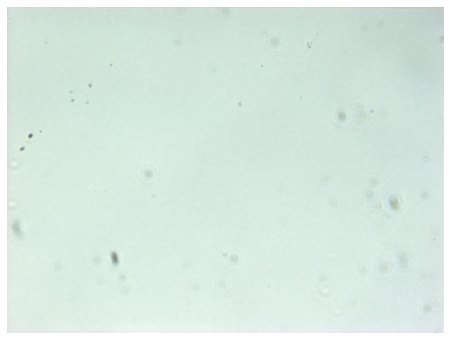

In [28]:
returns = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=False, estimate_background=True, focus_dive=True)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=True, background_image=returns[0])
export_slide(mag='4x')
pd_arr = pd.DataFrame(returns[1])
pd_arr.to_csv(os.path.join(save_path, acq_name+'-z_pos.csv'), index=False)
pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name+'-z_pos.csv'))
z_pos_4x = np.array(pd_arr_r)

In [18]:
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')

Imaging mode set as Brightfield


In [40]:
### no focus for shg
acq_name = 'BBS-14011-4x-v3'
position_lists_mp = annotations_positionlist(config, image_name=acq_name, out_mag='mp')
position_lists_mp = position_lists_mp[0]
acq_name = 'BBS-14011-shg-focus'
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_lists_mp, mda=True, z_stack=True, sample_depth=400, z_step=8, estimate_background=False, focus_dive=False)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='mp', mda=True, z_stack=True, position_list=position_lists_mp, flip_y=False, rotate=270, correction=True)
export_slide(mag='mp')

['qupath-projects\\mp-tiles\\BBS-14011-4x-v30.csv']
Imaging mode set as SHG
Dataset opened                 
 Processing tiles: 42/42
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-shg-focus\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-shg-focus\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 512x512x51px, channels=1, timepoints=1 (425 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] 

exporting slides, please wait...


 Processing tiles: 147/147
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-20x-v3\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (101 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-20x-v3\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (96 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\D

exporting slides, please wait...


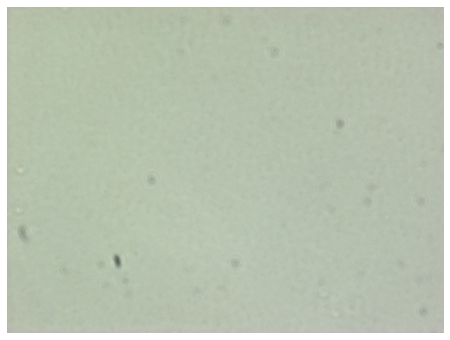

In [29]:
### test 20x only
position_list_z = returns[1]
acq_name = 'BBS-14011-4x-v3'
position_lists_20x = annotations_positionlist(config, image_name=acq_name, out_mag='20x')
position_list_20x = position_lists_20x[0]
position_list_xyz = np.concatenate((position_list, position_list_z.reshape((position_list.shape[0], position_list.shape[1], 1))), 2)
sampled_pos_xyz = resample_z_pos(config, mag='20x', xy_pos=position_list_20x, xyz_pos_list_4x=position_list_xyz)
acq_name = 'BBS-14011-20x-v3'
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=True, focus_dive=True)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=True, background_image=returns_20x[0])
export_slide(mag='20x')

In [30]:
### test shg only
position_list_z = returns[1]
acq_name = 'BBS-14011-4x-v3'
position_lists_mp = annotations_positionlist(config, image_name=acq_name, out_mag='mp')
position_lists_mp = position_lists_mp[0]
position_list_xyz_20x = np.concatenate((position_list_20x, returns_20x[-1].reshape((returns_20x[-1].shape[0], 1))), 1)
sampled_pos_xyz_mp = resample_z_pos(config, mag='mp', xy_pos=position_lists_mp, xyz_pos_list_20x=position_list_xyz_20x)
acq_name = 'BBS-14011-4-mp-v3-0'
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=sampled_pos_xyz_mp, mda=True, z_stack=True, sample_depth=36, z_step=6, estimate_background=False, focus_dive=False)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='mp', mda=True, z_stack=True, position_list=sampled_pos_xyz_mp, flip_y=False, rotate=270, correction=True)
export_slide(mag='mp')

['qupath-projects\\mp-tiles\\BBS-14011-4x-v30.csv']
Imaging mode set as SHG
Dataset opened                 
 Processing tiles: 142/663

ValueError: need at least one array to stack

In [34]:
sampled_pos_xyz_mp[100:200]

array([[20142.2088625 ,  3011.9824875 , -6765.53      ],
       [20142.2088625 ,  3126.97441875, -6765.53      ],
       [20142.2088625 ,  3241.96635   , -6764.29      ],
       [20142.2088625 ,  3356.95828125, -6764.29      ],
       [20142.2088625 ,  3471.9502125 , -6764.91      ],
       [20142.2088625 ,  3586.94214375, -6764.91      ],
       [20142.2088625 ,  3701.934075  , -6765.34579158],
       [20142.2088625 ,  3816.92600625, -6765.34579158],
       [20142.2088625 ,  3931.9179375 , -6765.53773547],
       [20142.2088625 ,  4046.90986875, -6765.53773547],
       [20142.2088625 ,  4161.9018    , -6765.66028056],
       [20142.2088625 ,  4276.89373125, -6765.66028056],
       [20142.2088625 ,  4391.8856625 , -6765.27294589],
       [20142.2088625 ,  4506.87759375, -6765.96657315],
       [20142.2088625 ,  4621.869525  , -6765.96657315],
       [20142.2088625 ,  4736.86145625, -6731.87      ],
       [20142.2088625 ,  4851.8533875 , -6731.87      ],
       [20257.20079375,   482.1

In [53]:
position_list_xyz_20x

array([[16834.126     ,  5878.6497956 , -7027.74      ],
       [16834.126     ,  6096.1475912 , -7022.47      ],
       [16834.126     ,  6313.6453868 , -7018.4       ],
       [16834.126     ,  6531.1431824 , -7015.08      ],
       [16834.126     ,  6748.640978  , -7012.8       ],
       [16834.126     ,  6966.1387736 , -7011.81      ],
       [16834.126     ,  7183.6365692 , -7012.58      ],
       [16834.126     ,  7401.1343648 , -7016.27      ],
       [17129.7677956 ,  5661.152     , -7037.59      ],
       [17129.7677956 ,  5878.6497956 , -7027.85      ],
       [17129.7677956 ,  6096.1475912 , -7045.83262525],
       [17129.7677956 ,  6313.6453868 , -7045.21749499],
       [17129.7677956 ,  6531.1431824 , -7045.35452906],
       [17129.7677956 ,  6748.640978  , -7045.23613226],
       [17129.7677956 ,  6966.1387736 , -7045.32661323],
       [17129.7677956 ,  7183.6365692 , -7045.83773547],
       [17129.7677956 ,  7401.1343648 , -7015.        ],
       [17129.7677956 ,  7618.6

In [55]:
position_lists_20x = annotations_positionlist(config, image_name=acq_name, out_mag='20x')

['qupath-projects\\20x-tiles\\Calibrate0.csv']


In [56]:
position_list_20x = position_lists_20x[0]

In [75]:
export_slide(mag='mp')

exporting slides, please wait...


In [57]:
position_list_20x

array([[8773.708    , 5447.042    ],
       [8773.708    , 5664.5397956],
       [8773.708    , 5882.0375912],
       [8773.708    , 6099.5353868],
       [8773.708    , 6317.0331824],
       [8773.708    , 6534.530978 ],
       [8773.708    , 6752.0287736],
       [8773.708    , 6969.5265692],
       [8773.708    , 7187.0243648],
       [8773.708    , 7404.5221604],
       [8773.708    , 7622.019956 ],
       [9069.3497956, 5447.042    ],
       [9069.3497956, 5664.5397956],
       [9069.3497956, 5882.0375912],
       [9069.3497956, 6099.5353868],
       [9069.3497956, 6317.0331824],
       [9069.3497956, 6534.530978 ],
       [9069.3497956, 6752.0287736],
       [9069.3497956, 6969.5265692],
       [9069.3497956, 7187.0243648],
       [9069.3497956, 7404.5221604],
       [9069.3497956, 7622.019956 ],
       [9364.9915912, 5447.042    ],
       [9364.9915912, 5664.5397956],
       [9364.9915912, 5882.0375912],
       [9364.9915912, 6099.5353868],
       [9364.9915912, 6317.0331824],
 

In [24]:
position_list_z = returns[1]
position_list_xyz = np.concatenate((position_list, position_list_z.reshape((position_list.shape[0], position_list.shape[1], 1))), 2)

In [25]:
position_list_xyz

array([[[    0.        ,     0.        , -2700.02      ],
        [ 1751.31      ,     0.        , -1937.4949499 ],
        [ 3502.62      ,     0.        , -1937.5       ],
        [ 5253.93      ,     0.        , -2300.02      ],
        [ 7005.24      ,     0.        , -2300.01      ],
        [ 8756.55      ,     0.        , -2300.01      ],
        [10507.86      ,     0.        , -2300.01      ],
        [12259.17      ,     0.        , -2300.01      ],
        [14010.48      ,     0.        , -2300.01      ],
        [15761.79      ,     0.        , -2095.80659319],
        [17513.1       ,     0.        , -2105.84004008],
        [19264.41      ,     0.        , -2113.46523046],
        [21015.72      ,     0.        , -2112.27759519],
        [22767.03      ,     0.        , -2101.46835671],
        [24518.34      ,     0.        , -2099.47599198],
        [26269.65      ,     0.        , -2101.48400802],
        [28020.96      ,     0.        , -2103.49400802],
        [29772

In [26]:
sampled_pos_xyz = resample_z_pos(config, mag='20x', xy_pos=position_list_20x, xyz_pos_list_4x=position_list_xyz)

In [27]:
sampled_pos_xyz

array([[24680.76      ,  9680.22      , -7286.13347656],
       [24680.76      ,  9924.66128   , -7288.42265665],
       [24680.76      , 10169.10256   , -7287.31820667],
       [24680.76      , 10413.54384   , -7284.16343606],
       [24680.76      , 10657.98512   , -7280.62393288],
       [24680.76      , 10902.4264    , -7277.7214122 ],
       [24680.76      , 11146.86768   , -7277.1215761 ],
       [24680.76      , 11391.30896   , -7278.7304327 ],
       [25015.31328   ,  9680.22      , -7285.66017798],
       [25015.31328   ,  9924.66128   , -7288.10817019],
       [25015.31328   , 10169.10256   , -7287.40481172],
       [25015.31328   , 10413.54384   , -7284.78575881],
       [25015.31328   , 10657.98512   , -7281.76211937],
       [25015.31328   , 10902.4264    , -7279.29064839],
       [25015.31328   , 11146.86768   , -7278.87635858],
       [25015.31328   , 11391.30896   , -7279.84834729],
       [25015.31328   , 11635.75024   , -7281.43726861],
       [25349.86656   ,  9680.2

In [ ]:
# batch 20x acquisition
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
save_path = 'data/acquisition'
acq_name = 'BBS-14011-4x-v3'
pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name+'-z_pos.csv'))
z_pos_4x = np.array(pd_arr_r)
position_list_z = z_pos_4x
position_list = generate_grid(config, mag='4x')
position_list_xyz = np.concatenate((position_list, position_list_z.reshape((position_list.shape[0], position_list.shape[1], 1))), 2)
position_lists_20x = annotations_positionlist(config, image_name=acq_name, out_mag='20x')
return_20x_list = []
for idx, roi in enumerate(position_lists_20x):
    print('Object: {}/{}'.format(idx+1, len(position_lists_20x)))
    acq_name = 'BBS-14011-20x-v3' + '-' + str(idx)
    sampled_pos_xyz = resample_z_pos(config, mag='20x', xy_pos=roi, xyz_pos_list_4x=position_list_xyz)
    if idx==0:
        returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=True, focus_dive=True)
        stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=True, background_image=returns_20x[0])
    else:
        returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=False, background_image=returns_20x[0], focus_dive=True)
        stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=False)
    export_slide(mag='20x', remove_file=False)
    return_20x_list.append(returns_20x[-1]) ### store focus map

 40/58 tiles done
 Diving focus at -3

 Diving focus at -2

 Diving focus at -1

 Diving focus at 0


In [129]:
export_slide(mag='20x', remove_file=False)

exporting slides, please wait...


In [ ]:
position_lists_20x = annotations_positionlist(config, image_name=acq_name, out_mag='20x')
position_list_20x = position_lists_20x[0]
acq_name = 'Calibrate-20x'
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=position_list_20x, mda=False, estimate_background=True, focus_dive=True)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=position_list_20x, flip_y=True, correction=True, background_image=returns_20x[0])

In [250]:
acq_name = 'slide-BIC-focus-test'
position_lists_mp = annotations_positionlist(config, image_name=acq_name, out_mag='mp')[0]

In [251]:
position_lists_mp

array([[ 1.48977000e+04,  1.22504445e+02],
       [ 1.48977000e+04,  2.41234260e+02],
       [ 1.48977000e+04,  3.59964074e+02],
       [ 1.48977000e+04,  4.78693889e+02],
       [ 1.48977000e+04,  5.97423704e+02],
       [ 1.48977000e+04,  7.16153519e+02],
       [ 1.48977000e+04,  8.34883334e+02],
       [ 1.48977000e+04,  9.53613149e+02],
       [ 1.48977000e+04,  1.07234296e+03],
       [ 1.50164298e+04,  3.77462978e+00],
       [ 1.50164298e+04,  1.22504445e+02],
       [ 1.50164298e+04,  2.41234260e+02],
       [ 1.50164298e+04,  3.59964074e+02],
       [ 1.50164298e+04,  4.78693889e+02],
       [ 1.50164298e+04,  5.97423704e+02],
       [ 1.50164298e+04,  7.16153519e+02],
       [ 1.50164298e+04,  8.34883334e+02],
       [ 1.50164298e+04,  9.53613149e+02],
       [ 1.50164298e+04,  1.07234296e+03],
       [ 1.50164298e+04,  1.19107278e+03],
       [ 1.50164298e+04,  1.30980259e+03],
       [ 1.51351596e+04, -1.14955185e+02],
       [ 1.51351596e+04,  3.77462978e+00],
       [ 1.

In [252]:
position_list_xyz_20x = np.concatenate((position_list_20x, returns_20x[1]), 1)

In [253]:
position_list_xyz_20x

array([[19985.37      ,  4796.91      , -7211.97      ],
       [19985.37      ,  5050.33291095, -7217.46      ],
       [19985.37      ,  5303.75582189, -7194.33      ],
       [19985.37      ,  5557.17873284, -7197.37      ],
       [19985.37      ,  5810.60164378, -7193.68      ],
       [19985.37      ,  6064.02455473, -7197.98635271],
       [19985.37      ,  6317.44746567, -7195.87587174],
       [20328.89883484,  4796.91      , -7190.22      ],
       [20328.89883484,  5050.33291095, -7196.12      ],
       [20328.89883484,  5303.75582189, -7198.22      ],
       [20328.89883484,  5557.17873284, -7196.23      ],
       [20328.89883484,  5810.60164378, -7192.41      ],
       [20328.89883484,  6064.02455473, -7196.88699399],
       [20328.89883484,  6317.44746567, -7194.51603206],
       [20672.42766967,  4796.91      , -7188.46      ],
       [20672.42766967,  5050.33291095, -7194.79      ],
       [20672.42766967,  5303.75582189, -7197.06      ],
       [20672.42766967,  5557.1

In [254]:
sampled_pos_xyz_mp = resample_z_pos_d(config, mag='mp', xy_pos=position_lists_mp, xyz_pos_list_20x=position_list_xyz_20x)

In [255]:
sampled_pos_xyz_mp

array([[ 1.48977000e+04,  1.22504445e+02, -6.68697000e+03],
       [ 1.48977000e+04,  2.41234260e+02, -6.68697000e+03],
       [ 1.48977000e+04,  3.59964074e+02, -6.68697000e+03],
       [ 1.48977000e+04,  4.78693889e+02, -6.68697000e+03],
       [ 1.48977000e+04,  5.97423704e+02, -6.68697000e+03],
       [ 1.48977000e+04,  7.16153519e+02, -6.68697000e+03],
       [ 1.48977000e+04,  8.34883334e+02, -6.68697000e+03],
       [ 1.48977000e+04,  9.53613149e+02, -6.68697000e+03],
       [ 1.48977000e+04,  1.07234296e+03, -6.68697000e+03],
       [ 1.50164298e+04,  3.77462978e+00, -6.68697000e+03],
       [ 1.50164298e+04,  1.22504445e+02, -6.68697000e+03],
       [ 1.50164298e+04,  2.41234260e+02, -6.68697000e+03],
       [ 1.50164298e+04,  3.59964074e+02, -6.68697000e+03],
       [ 1.50164298e+04,  4.78693889e+02, -6.68697000e+03],
       [ 1.50164298e+04,  5.97423704e+02, -6.68697000e+03],
       [ 1.50164298e+04,  7.16153519e+02, -6.68697000e+03],
       [ 1.50164298e+04,  8.34883334e+02

In [233]:
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')

Imaging mode set as SHG


In [31]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-test-annotation-mp-dive'
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list_mp, mda=True, z_stack=True, sample_depth=20, z_step=4, estimate_background=False, focus_dive=False)

In [13]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-shg-256'
stitching(config, ij, save_path=save_path, acq_name=acq_name, mod='shg', mag='20x', mda=True, z_stack=True, position_list=position_list_mp, flip_y=False, rotate=270, correction=True)

Dataset opened                 
 Processing tiles: 1429/1429
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-shg-256\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-shg-256\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x10px, channels=1, timepoints=1 (610 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString

In [33]:
export_slide(mag='mp', remove_file=True)

exporting slides, please wait...


In [29]:
qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3 (console).exe')
image_dirs = glob.glob(os.path.join('data', 'slides', 'mp', '*.tif'))
script = os.path.join('qupath-scripts', 'export-ometif-metadata-mp.groovy')  
subprocess.run([qupath, "script", script, "-i", image_dirs[0]], shell=True)

CompletedProcess(args=['QuPath-0.2.3\\QuPath-0.2.3 (console).exe', 'script', 'qupath-scripts\\export-ometif-metadata-mp.groovy', '-i', 'data\\slides\\mp\\slide-sample-shg-256.tif'], returncode=0)

In [159]:
def stitching_d(config, ij, save_path, acq_name, mag='4x', mda=True, z_stack=False, position_list=None, flip_x=False, flip_y=False, rotate=None, correction=False, background_image=None, move_stitched_image=True):
#     position_list_flat = position_list.reshape(-1, 2)
    stitch_folder = os.path.join('data/stitching/tiles', acq_name)
    os.makedirs(stitch_folder, exist_ok=True)
    out_folder = os.path.join('data/stitching/stitched', acq_name)
    os.makedirs(out_folder, exist_ok=True)
    slide_folder = os.path.join('data/slides', mag)
    os.makedirs(slide_folder, exist_ok=True)
    if mag == '20x':
        pixel_size = config["pixel-size-bf-20x"]
    if mag == '4x':
        pixel_size = config["pixel-size-bf-4x"]
    if mag == 'mp':
        pixel_size = config["pixel-size-shg"]
    if mda:
        data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
        dataset = Dataset(data_path)
    else:
        image_list = glob.glob(os.path.join(glob.glob(save_path+'/'+acq_name+'*')[-1], '*.tiff'))
        image_list.sort(key=lambda x: os.path.getmtime(x))
    if correction is True and background_image is not None:
        image_list = image_list[0:-1]
        bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
    with open(os.path.join(stitch_folder, 'TileConfiguration.txt'), 'w') as text_file:
        if z_stack:
            print('dim = {}'.format(3), file=text_file)
        else:
            print('dim = {}'.format(2), file=text_file)
        for pos in range(position_list.shape[0]):
            x = int(position_list[pos, 0] / pixel_size)
            y = int(position_list[pos, 1] / pixel_size)
            if z_stack:
                print('{}.tiff; ; ({}, {}, {})'.format(pos, x, y, 0), file=text_file)
                z_idx = 0
                img_z_list = []
                while(dataset.has_image(position=pos, z=z_idx)):
                    img = dataset.read_image(position=pos, z=z_idx)
                    if correction is True and background_image is None:
                        img = exposure.rescale_intensity(img, in_range=(6500, 12000), out_range=(0, 1))
                    if rotate is not None:
                        img = transform.rotate(np.array(img), rotate)
                    img_z_list.append(img)
                    z_idx = z_idx+1
                img = np.stack(img_z_list, axis=0)
            else:    
                print('{}.tiff; ; ({}, {})'.format(pos, x, y), file=text_file)
                if mda:
                    img = dataset.read_image(position=pos)
                else:
                    img = io.imread(image_list[pos])
                if correction is True and background_image is not None:
                    img = white_balance(img, background_image)
                    img = flat_field(img, bg_img)
                if rotate is not None:
                    img = transform.rotate(img, rotate)
#             print(img)
            if flip_y:
                img = img[::-1, :]
            if flip_x:
                img = img[:, ::-1]
            sys.stdout.write('\r Processing tiles: {}/{}'.format(pos+1, position_list.shape[0]))
            io.imsave(stitch_folder+'/{}.tiff'.format(pos), img_as_ubyte(img))
    sys.stdout.write('\n stitching, please wait...')
    temp_channel_folder = 'data/stitching/channel_temp'
    os.makedirs(temp_channel_folder, exist_ok=True)
    params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
            'directory':stitch_folder, 'ayout_file': 'TileConfiguration.txt', 
            'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
            'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
            'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
            'image_output': 'Write to disk', 'output_directory': temp_channel_folder}
    plugin = "Grid/Collection stitching"
    ij.py.run_plugin(plugin, params)
    
    if mag=='20x' or mag=='4x': 
        macro = """
            #@ String inDir
            #@ String outDir
            slices = getFileList(inDir);
            for (i=0;i<lengthOf(slices);i=i+1) {
                filePath = inDir + '/' + slices[i];
                open(filePath);
            }
            run("Merge Channels...", "c1=img_t1_z1_c1 c2=img_t1_z1_c2 c3=img_t1_z1_c3 create");
            saveAs("Tiff", outDir);
            """
    if mag=='mp':
        macro = """
            #@ String inDir
            #@ String outDir
            slices = getFileList(inDir);
            for (i=0;i<lengthOf(slices);i=i+1) {
                filePath = inDir + '/' + slices[i];
                open(filePath);
            }
            run("Images to Stack", "name=Stack title=[] use");;
            saveAs("Tiff", outDir);
            run("Z Project...", "projection=[Max Intensity]");
            saveAs("Tiff", outDir);
            """

    if move_stitched_image:
        args = {
                'inDir' : os.path.join(os.getcwd(), temp_channel_folder),
                'outDir' : os.path.join(os.getcwd(), os.path.join(slide_folder, acq_name+'.tif'))
            }
    else:
        args = {
                'inDir' : os.path.join(os.getcwd(), temp_channel_folder),
                'outDir' : os.path.join(os.getcwd(), os.path.join(out_folder, 'fused.tif'))
            }

    result = ij.py.run_macro(macro, args)
    shutil.rmtree(temp_channel_folder)
#     shutil.rmtree(stitch_folder)

In [45]:
def autofocus_d(config, core, method='edge', mag='4x', rgb=True, search_range=45, steps=5, snap=True, crop_ratio=1.0, flip_channel=True, check_background=True, offset=0):
    if mag=='4x':
        drift_limit = config["Z-stage-4x"]
    if mag=='20x':
        drift_limit = config["Z-stage-20x"]
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = search_range/steps
    scores = []
    positions = []
    count = 0
    for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
        position_z = step * interval_z + current_z
        if position_z < config["hard-limit-z"][0] or position_z > config["hard-limit-z"][1]:
            print("z-stage out of range, new focus discarded")
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if check_background and step==-int(np.floor(steps/2)):
            bg_flag = is_background_d(pixels)
            if bg_flag:
                core.set_position(drift_limit)
                core.wait_for_system()
#                 print("Is background")
                return current_z, pixels, bg_flag
        img_gray = color.rgb2gray(pixels)
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        if method == 'edge':
            score = np.mean(sobel(img_gray))
        print(str(score) + " " + str(position_z))
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions) 
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    if focus_z < config["hard-limit-z"][0] or focus_z > config["hard-limit-z"][1]:
        print("z-stage out of range, new focus discarded")
        focus_z = position_z
    if np.abs(focus_z-drift_limit) > 1000:
        print("z-stage out of range, reset focus")
        focus_z = drift_limit
        core.set_position(focus_z)
        core.wait_for_system()
    else:
        core.set_position(focus_z)
        core.wait_for_system()
    if snap:
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        return focus_z+offset, pixels, False
    else:
        return focus_z+offset, None, False

def is_background_d(img, t=0.275):
#     img = transform.resize(img, (1024, 1024))
    patch_h = int(img.shape[0]/8)
    patch_w = int(img.shape[1]/8)
    img = color.rgb2hsv(img)
    img_windows = np.squeeze(view_as_windows(img, (patch_h, patch_w, 3), step=(patch_h, patch_w, 3)))
    img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], patch_h, patch_w, 3)) # nxm, 256, 256, 3
    img_max = np.max(img_windows, axis=0) # 256x256x3
    img_min = np.min(img_windows, axis=0) # 256x256x3
    sat_img = img_max[:, :, 1]
    bright_img = 1-img_min[:, :, 2]
    ave_sat = np.sum(sat_img)/(patch_h*patch_w)
    ave_bright = np.sum(bright_img)/(patch_h*patch_w)
    print(ave_sat)
    print(ave_bright)
    return ave_sat < t and ave_bright < t*2

In [39]:
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')

Imaging mode set as SHG


In [303]:
focus, _, _ = autofocus_d(config, core, mag='20x', method='edge', snap=False, search_range=200)

0.34681546066934854
0.38255092664828977
0.00885475072450438 -7296.01
0.010393121274432718 -7256.01
0.016044910001763033 -7216.01
0.02539321888471101 -7176.01
0.010515668036329499 -7136.01


In [304]:
focus

-7171.280541082165

In [326]:
pos_z, _, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=100, steps=7, check_background=True, snap=False)
pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=False, snap=True)
pos_z

0.40022592354778747
0.42244898666805364


-7222.3740681362715

In [323]:
pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=280, steps=5, check_background=True, snap=False)
_, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=75, steps=5, check_background=False, snap=False)
pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=False, snap=True)
pos_z

0.3471960469108318
0.32723149737348517


-7205.174729458919

In [308]:
focus

-7191.039398797594

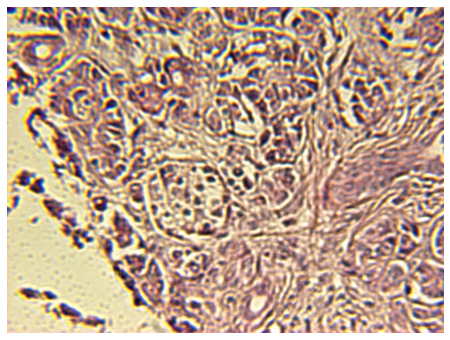

In [43]:
pixels = snap_image(core, rgb=True, flip_channel=True)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels))
plt.axis("off")
plt.show()

In [46]:
is_background_d(pixels)

0.6151380476556472
0.6178159185867096


False

In [57]:
img = color.rgb2hsv(pixels)
img_windows = np.squeeze(view_as_windows(img, (174, 260, 3), step=256))
img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], 174, 260, 3)) # nxm, 256, 256, 3
img_max = np.max(img_windows, axis=0) # 256x256x3
sat_img = 1-img_max[:, :, 2]
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(sat_img))
plt.axis("off")
plt.show()

ValueError: cannot reshape array of size 2714400 into shape (20,256,256,3)

In [54]:
np.sum(sat_img)/(256*256)

0.008855602787990196

In [12]:
annotation_path = filedialog.askopenfilename(filetypes=(("Json annotation files","*.json"),("All files","*.*")))
coords = extract_rois(config, 'example/qupath-pj/annotation results/BIC14011b.jpg.json', image_size=(22689, 15080))

FileNotFoundError: [Errno 2] No such file or directory: 'example/qupath-pj/annotation results/BIC14011b.jpg.json'

In [141]:
bposition_list_z = focus_dive(core, position_list, search_range=18, resample_grid_size=(position_list_20x.shape[0], position_list_20x.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]


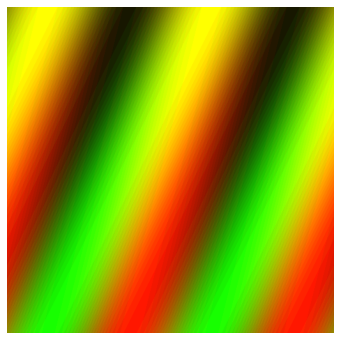

In [25]:
core.set_position(20)
core.wait_for_system()
core.snap_image()
tagged_image = core.get_tagged_image()
rgb = True
if rgb == True:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
        )
else:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
pixels = pixels[:, :, 0:3]
pixels=np.flip(pixels, 2)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [ ]:
### load libraries
bridge = Bridge()
core = bridge.get_core()
ij = imagej.init('fiji\\fiji\\Fiji.app')
Image.MAX_IMAGE_PIXELS = None  
core.set_timeout_ms(20000)

In [ ]:
### collect brightfield image
save_path = 'data/acquisition'
acq_name = 'slide-bf-test'
position_list, grid = generate_grid(config, mag='4x')
estimated_background_img = whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=False, core=core, estimate_background=True) # acquire 4x bf
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_img) # stitch 4x bf

In [14]:
def export_slide(mag='4x'):
    if mag=='4x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-4x.groovy')
    if mag=='20x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-20x.groovy')
    if mag=='mp':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-shg.groovy')       
    qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
    image_dirs = glob.glob(os.path.join('data', 'slides', '*.tif'))
    for img_dir in image_dirs:
        if img_dir.find("ome") != -1:
            continue
        subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)
        os.remove(img_dir)

In [ ]:
def annotations_to_positions(config, image_type='4x'):
    if image_type == '4x':
        coords_csvs = glob.glob("qupath-projects/4x-tiles/*.csv")
    if image_type == '20x':
        off_set = config["20x-bf-offset"]
        coords_csvs = glob.glob("qupath-projects/20x-tiles/*.csv")
    if image_type == 'shg':
        off_set = config["shg-offset"]
        coords_csvs = glob.glob("qupath-projects/mp-tiles/*.csv")
    coords_list = []
    for coords_csv in coords_csvs:
        coords_df = pd.read_csv(coords_csv)
        coords_array = np.array(coords_df)
        coords_array[:, 0] = coords_array[:, 0] + offset[0]
        coords_array[:, 1] = coords_array[:, 1] + offset[1]
        coords_list.append(coords_array)
    return coords_list

In [9]:
coords_list

[array([[   0.,    0.],
        [   0.,  990.],
        [   0., 1980.],
        [   0., 2970.],
        [1270.,    0.],
        [1270.,  990.],
        [1270., 1980.],
        [1270., 2970.],
        [2540.,    0.],
        [2540.,  990.],
        [2540., 1980.],
        [2540., 2970.],
        [3810.,    0.],
        [3810.,  990.],
        [3810., 1980.],
        [3810., 2970.]])]

In [21]:
script = os.path.join('qupath-scripts', 'export-entire-image-as-patches-4x.groovy')
qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
image_dirs = glob.glob(os.path.join('data', 'slides', '*.tiff'))
for img_dir in image_dirs:
    subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)

In [22]:
macro = """
    #@ String inDir
    #@ String outDir
    slices = getFileList(inDir);
    for (i=0;i<lengthOf(slices);i=i+1) {
        filePath = inDir + '/' + slices[i];
        open(filePath);
    }
    run("Merge Channels...", "c1=img_t1_z1_c1 c2=img_t1_z1_c2 c3=img_t1_z1_c3 create");
    saveAs("Tiff", outDir);
    """
args = {
        'inDir': os.path.join(os.getcwd(), 'data/stitching/channel_temp'),
        'outDir' : os.path.join(os.getcwd(), os.path.join('data/slides', acq_name+'.tif'))
    }

In [23]:
result = ij.py.run_macro(macro, args)

In [ ]:
os.getcwd()

 Processing tiles: 44/44
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\Calibrate-20x\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (97 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\Calibrate-20x\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (96 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Document

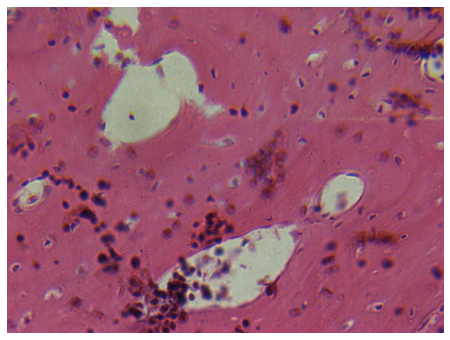

In [63]:
acq_name = 'Calibrate-20x'
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=position_list_20x, mda=False, estimate_background=True, focus_dive=True)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=position_list_20x, flip_y=True, correction=True, background_image=returns_20x[0])

In [ ]:
acq_name = 'Calibrate-shg'
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_lists_shg, mda=True, z_stack=True, sample_depth=40, z_step=5, estimate_background=False, focus_dive=False)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='mp', mda=True, z_stack=True, position_list=position_lists_shg, flip_y=False, rotate=270, correction=True)